# Synthetic Sign Classification
### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import seaborn as sns

from PIL import Image

import time
import copy

In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.functional as F

In [3]:
from signutils.data import create_image_dataframe
from signutils.data import SyntheticSignData, MakeSquare, RotateImage, ResizeImage, ToTensor, NormalizeImage, UnNormalizeImage
from signutils.train import train_model, format_training_records
from signutils.models import load_pretrained_model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device {device}")

Using Device cuda


## Read Image Information Dataframe

In [6]:
with open('./Synthetic/basic_classification_results/trial-EfficientNet-10-Adam-001-0/encoder.json') as fl:
    label_encoder = json.loads(json.load(fl))
label_decoder = {label_encoder[key]: key for key in label_encoder.keys()}

In [6]:
# def process_image_dataframe(df, label_encoder):
#     df['label'] = df['labelname'].map(label_encoder)
#     df = df.dropna().reset_index(drop=True)
#     df['label'] = df['label'].apply(int)
#     return df

In [7]:
# df_mike_udot = create_image_dataframe('./images_mike/udot_crop')
# df_mike_tdot = create_image_dataframe('./images_mike/tdot_crop')
# df_yoshi = create_image_dataframe('./images_yoshi/DataLabeling')

# df_mike_udot = process_image_dataframe(df_mike_udot, label_encoder)
# df_mike_tdot = process_image_dataframe(df_mike_tdot, label_encoder)
# df_yoshi = process_image_dataframe(df_yoshi, label_encoder)

In [8]:
# df_synth_0 = create_image_dataframe('./Synthetic/basic_classification/')
# df_synth_1 = create_image_dataframe('./Synthetic/synth_classification/')

# df_synth_0 = process_image_dataframe(df_synth_0, label_encoder)
# df_synth_1 = process_image_dataframe(df_synth_1, label_encoder)

In [9]:
# df_m15 = pd.read_csv('m1-5_info.csv')
# df_m15 = df_m15.dropna()
# valid_images = df_m15['image name'].values

In [10]:
# def filter_m15(labelname, filename, valid_images=valid_images):
#     if labelname == 'm1-5':
#         if filename in valid_images:
#             return 1
#         else:
#             return 0
#     else:
#         return 1

In [11]:
# df_synth_1['temp'] = df_synth_1[['labelname', 'filename']].apply(lambda x: filter_m15(x[0], x[1], valid_images), axis=1)
# df_synth_1 = df_synth_1[df_synth_1['temp']==1].reset_index(drop=True).drop('temp', axis=1)

In [12]:
# df_real = pd.concat([df_mike_tdot, df_yoshi])
# df_real = pd.concat([df_real for i in range(3)])

# df = pd.concat([df_synth_0, df_synth_1, df_real])

# df_test = df_mike_udot

In [15]:
# df.to_csv('classification_train.csv', index=False)
# df_test.to_csv('classification_test.csv', index=False)

In [8]:
df = pd.read_csv('classification_train.csv')
df_test = pd.read_csv('classification_test.csv')

## Format data into train and validation datasets
### Perform the train validation split

In [9]:
split = 7/10
total_samples = len(df)
split_idx = int(np.floor(total_samples * split))

index = np.arange(total_samples)
np.random.seed(123)
np.random.shuffle(index)

train_idx, val_idx = index[:split_idx], index[split_idx:]

print("Data Split")
print(f"Number of training images:   {len(train_idx)}")
print(f"Number of validation images: {len(val_idx)}")

Data Split
Number of training images:   270519
Number of validation images: 115938


### Create Datasets

In [10]:
norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

dataset_train = SyntheticSignData(df.iloc[train_idx, :], transform=transforms.Compose([
    MakeSquare(),
    ResizeImage((64, 64)),
    RotateImage(p=0.5, degrees=20),
    ToTensor(),
    NormalizeImage(norm_mean, norm_std)
]))

dataset_val = SyntheticSignData(df.iloc[val_idx, :], transform=transforms.Compose([
    MakeSquare(),
    ResizeImage((64, 64)),
    ToTensor(),
    NormalizeImage(norm_mean, norm_std)
]))

dataset_test = SyntheticSignData(df_test, transform=transforms.Compose([
    MakeSquare(),
    ResizeImage((64, 64)),
    ToTensor(),
    NormalizeImage(norm_mean, norm_std)
]))

dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_val)}
unnormalize_image = UnNormalizeImage(mean=norm_mean, std=norm_std)

In [11]:
transform_in=transforms.Compose([
    MakeSquare(),
    ResizeImage((64, 64)),
    ToTensor(),
    NormalizeImage(norm_mean, norm_std)
])

### Visualize image from dataset

Total Images: 270519


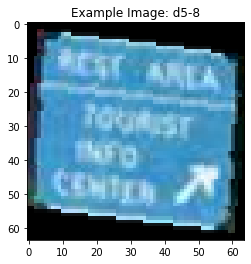

In [12]:
idx = np.random.randint(len(dataset_train))
image, label = dataset_train[idx]
im = image.clone().to(device='cpu').detach()
im = unnormalize_image(im).transpose((1, 2, 0))

print(f"Total Images: {len(dataset_train)}")

plt.imshow(im)
plt.title(f"Example Image: {label_decoder[int(label)]}")
plt.show()

## Create DataLoaders

In [13]:
batch_size=256

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

dataloaders = {'train': dataloader_train, 'val': dataloader_val}

In [27]:
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Set Modeling Parameters
### Select model and change the final fully connected layer

In [11]:
out_ftrs = len(np.unique(dataset_train.labels))

model = load_pretrained_model('efficientnet_b0', out_ftrs)
model = model.to(device=device)

In [12]:
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

## Train the Model

In [13]:
num_epochs=10

model, loss_record, acc_record = train_model(model, 
                                             criterion, 
                                             optimizer,
                                             dataloaders=dataloaders,
                                             dataset_sizes=dataset_sizes,
                                             device=device,
                                             num_epochs=num_epochs, 
                                             scheduler=None, 
                                             print_every=100)

out_name = f"trial-{model.__class__.__name__}-{num_epochs}-{optimizer.__class__.__name__}-{str(lr).split('.')[-1]}-0"

Epoch 0/9
----------------------------------------------------------------------
Batch: 0000, loss: 6.47612 time: 0.001
Batch: 0100, loss: 0.95149 time: 0.009
Batch: 0200, loss: 0.33391 time: 0.017
Batch: 0300, loss: 0.15517 time: 0.026
Batch: 0400, loss: 0.22608 time: 0.037
Batch: 0500, loss: 0.13018 time: 0.045
Batch: 0600, loss: 0.10354 time: 0.056
Batch: 0700, loss: 0.10570 time: 0.065
Batch: 0800, loss: 0.07697 time: 0.075
Batch: 0900, loss: 0.08836 time: 0.086
Batch: 1000, loss: 0.06780 time: 0.095
Epoch: 0000, Phase: train, Loss: 0.44036, Acc: 0.89420, Time: 0.100
Epoch: 0000, Phase: val  , Loss: 0.05831, Acc: 0.98295, Time: 0.142

Epoch 1/9
----------------------------------------------------------------------
Batch: 0000, loss: 0.12862 time: 0.142
Batch: 0100, loss: 0.07339 time: 0.151
Batch: 0200, loss: 0.03777 time: 0.161
Batch: 0300, loss: 0.02461 time: 0.172
Batch: 0400, loss: 0.07010 time: 0.180
Batch: 0500, loss: 0.02869 time: 0.191
Batch: 0600, loss: 0.05711 time: 0.200

In [14]:
df_loss_epoch, df_loss_batch, df_acc = format_training_records(loss_record=loss_record, acc_record=acc_record)

In [15]:
# make results folder
results_path = os.path.join('Synthetic', 'basic_classification_results', out_name)
if not os.path.isdir(results_path):
    os.mkdir(results_path)

# format loss and accuracy
df_loss_epoch, df_loss_batch, df_acc = format_training_records(loss_record=loss_record, acc_record=acc_record)

# save model weights
torch.save(model.state_dict(), os.path.join(results_path, "model_weights.pth"))
# save entire model
torch.save(model, os.path.join(results_path, "model_entire.pth"))

# save label encoder
json_encoder = json.dumps(label_encoder)     
with open(os.path.join(results_path, "encoder.json"), "w") as outfile:
    json.dump(json_encoder, outfile)

# save training results
df_loss_epoch.to_csv(os.path.join(results_path, "loss_epoch.csv"), index=False)
df_loss_batch.to_csv(os.path.join(results_path, "loss_batch.csv"), index=False)
df_acc.to_csv(os.path.join(results_path, "accuracy.csv"), index=False)

## Review Model
### Review loss and accuracy curves

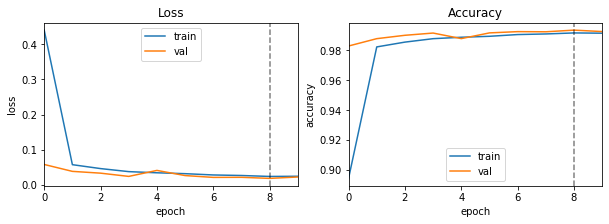

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
df_loss_epoch.plot(ax=ax[0])
df_acc.plot(ax=ax[1])

best_epoch = df_acc['val'].values.argmax()

for i, lab in enumerate(['loss', 'accuracy']):
    ax[i].set_ylabel(lab)
    ax[i].set_title(lab.capitalize())
    ax[i].set_xlabel('epoch')
    ax[i].axvline(x=best_epoch, c='k', ls='--', alpha=0.5)
    
plt.show()

In [ ]:
out_ftrs = len(np.unique(dataset_train.labels))

for num_epochs in [5, 10]:
    for i in range(3):

        model = load_pretrained_model('efficientnet_b0', out_ftrs)
        model = model.to(device=device)

        lr=0.001
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()



        model, loss_record, acc_record = train_model(model, 
                                                     criterion, 
                                                     optimizer,
                                                     dataloaders=dataloaders,
                                                     dataset_sizes=dataset_sizes,
                                                     device=device,
                                                     num_epochs=num_epochs, 
                                                     scheduler=None, 
                                                     print_every=100)

        out_name = f"trial2-{model.__class__.__name__}-{num_epochs}-{optimizer.__class__.__name__}-{str(lr).split('.')[-1]}-{i}"

        df_loss_epoch, df_loss_batch, df_acc = format_training_records(loss_record=loss_record, acc_record=acc_record)

        # make results folder
        results_path = os.path.join('Synthetic', 'basic_classification_results', out_name)
        if not os.path.isdir(results_path):
            os.mkdir(results_path)

        # format loss and accuracy
        df_loss_epoch, df_loss_batch, df_acc = format_training_records(loss_record=loss_record, acc_record=acc_record)

        # save model weights
        torch.save(model.state_dict(), os.path.join(results_path, "model_weights.pth"))
        # save entire model
        torch.save(model, os.path.join(results_path, "model_entire.pth"))

        # save label encoder
        json_encoder = json.dumps(label_encoder)     
        with open(os.path.join(results_path, "encoder.json"), "w") as outfile:
            json.dump(json_encoder, outfile)

        # save training results
        df_loss_epoch.to_csv(os.path.join(results_path, "loss_epoch.csv"), index=False)
        df_loss_batch.to_csv(os.path.join(results_path, "loss_batch.csv"), index=False)
        df_acc.to_csv(os.path.join(results_path, "accuracy.csv"), index=False)

Epoch 0/4
----------------------------------------------------------------------
Batch: 0000, loss: 6.47289 time: 0.001
Batch: 0100, loss: 0.72416 time: 0.009
Batch: 0200, loss: 0.29035 time: 0.017
Batch: 0300, loss: 0.24506 time: 0.026
Batch: 0400, loss: 0.12683 time: 0.036
Batch: 0500, loss: 0.12490 time: 0.045
Batch: 0600, loss: 0.12863 time: 0.056
Batch: 0700, loss: 0.13198 time: 0.067
Batch: 0800, loss: 0.07738 time: 0.076
Batch: 0900, loss: 0.07215 time: 0.086
Batch: 1000, loss: 0.04149 time: 0.095
Epoch: 0000, Phase: train, Loss: 0.42056, Acc: 0.90058, Time: 0.102
Epoch: 0000, Phase: val  , Loss: 0.04611, Acc: 0.98518, Time: 0.142

Epoch 1/4
----------------------------------------------------------------------
Batch: 0000, loss: 0.05032 time: 0.142
Batch: 0100, loss: 0.02619 time: 0.153
Batch: 0400, loss: 0.09409 time: 0.184
Batch: 0500, loss: 0.05167 time: 0.193
Batch: 0900, loss: 0.08729 time: 0.232
Batch: 1000, loss: 0.03072 time: 0.243
Epoch: 0001, Phase: train, Loss: 0.054

Batch: 0300, loss: 0.03595 time: 0.456
Batch: 0400, loss: 0.02424 time: 0.464
Batch: 0500, loss: 0.05106 time: 0.475
Batch: 0600, loss: 0.05252 time: 0.483
Batch: 0700, loss: 0.00968 time: 0.494
Batch: 0800, loss: 0.02016 time: 0.505
Batch: 0900, loss: 0.02633 time: 0.513
Batch: 1000, loss: 0.06402 time: 0.524
Epoch: 0003, Phase: train, Loss: 0.03578, Acc: 0.98834, Time: 0.528
Epoch: 0003, Phase: val  , Loss: 0.02775, Acc: 0.99123, Time: 0.567

Epoch 4/4
----------------------------------------------------------------------
Batch: 0000, loss: 0.03799 time: 0.567
Batch: 0100, loss: 0.00293 time: 0.578
Batch: 0200, loss: 0.01727 time: 0.589
Batch: 0300, loss: 0.04406 time: 0.597
Batch: 0400, loss: 0.01301 time: 0.608
Batch: 0500, loss: 0.00901 time: 0.616
Batch: 0600, loss: 0.01766 time: 0.627
Batch: 0700, loss: 0.05463 time: 0.636
Batch: 0800, loss: 0.11848 time: 0.646
Batch: 0900, loss: 0.04413 time: 0.657
Batch: 1000, loss: 0.01117 time: 0.665
Epoch: 0004, Phase: train, Loss: 0.03415,

In [212]:
# results = sorted(glob('./Synthetic/basic_classification_results/trial-EfficientNet-10-Adam*'))
# results = sorted(glob('./Synthetic/basic_classification_results/trial2-EfficientNet-5-Adam*')) # trial 1 (2)
results = sorted(glob('./Synthetic/basic_classification_results/trial2-EfficientNet-10-Adam*')) # trial 0 (1)
results

['./Synthetic/basic_classification_results/trial2-EfficientNet-10-Adam-001-0',
 './Synthetic/basic_classification_results/trial2-EfficientNet-10-Adam-001-1',
 './Synthetic/basic_classification_results/trial2-EfficientNet-10-Adam-001-2']

In [213]:
df_results=[]
for i, fldr in enumerate(results):
    
    temp = pd.read_csv(os.path.join(fldr, 'accuracy.csv'))
    temp['trial'] = i
    
    df_results.append(temp)
    
df_results = pd.concat(df_results)
df_results.reset_index(inplace=True)
df_results.columns = ['Epoch', 'Training', 'Validation', 'trial']

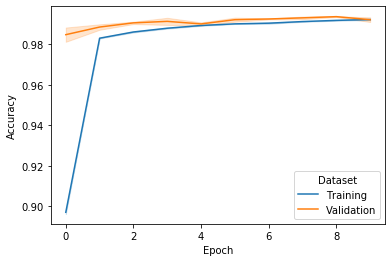

In [214]:
df_results_melt = df_results.melt(id_vars=['Epoch', 'trial'])
df_results_melt.columns = ['Epoch', 'trial', 'Dataset', 'Accuracy']

sns.lineplot(data=df_results_melt, x='Epoch', y='Accuracy', hue='Dataset', ci='sd')
plt.show()

In [188]:
def get_top_k_accuracy(predictions, labels, k=5):
    
    pred_val, pred_idx = predictions.sort(dim=1, descending=True)
    
    top_k=[]
    for i in range(len(labels)):
        top_k.append(labels[i] in pred_idx[i, :k])
        
    top_k = torch.tensor(top_k)
    acc = top_k.sum() / len(top_k)
    
    return acc.item(), top_k

In [222]:
for i, fldr in enumerate(results):
    model = torch.load(os.path.join(fldr, 'model_entire.pth'))
    
    model = model.to(device=device)
    model.eval()
    total_correct=0
    pred_all=[]
    y_all=[]
    for b in dataloader_test:
        X, y = b
        X = X.to(device=device)
        y = y.to(device=device)
        with torch.no_grad():
            pred = model(X)
        pred_all.append(pred.clone())
        y_all.append(y)

    pred_all = torch.concat(pred_all)
    y_all = torch.concat(y_all)
    
    accuracies=[]
    k_values = np.arange(1, 51)
    for k in k_values:
        acc, topk = get_top_k_accuracy(pred_all, y_all, k=k)
        accuracies.append(acc)
    accuracies = np.array(accuracies)
    
    df_test_acc = pd.DataFrame({'Accuracy': accuracies, 'k': k_values})
#     df_test_acc.to_csv(os.path.join(fldr, 'accuracy_k_test.csv'), index=False)

In [226]:
df_results_test=[]
for i, fldr in enumerate(results):
    
    temp = pd.read_csv(os.path.join(fldr, 'accuracy_k_test.csv'))
    temp['trial'] = i
    
    df_results_test.append(temp)
    
df_results_test = pd.concat(df_results_test)
df_results_test.reset_index(inplace=True, drop=True)

In [259]:
df_acc_bar = df_results[df_results['Epoch']==9].reset_index(drop=True).drop('Epoch', axis=1)
df_acc_bar['Test'] = df_results_test[df_results_test['k']==1]['Accuracy'].values
df_acc_bar = df_acc_bar.melt(id_vars='trial')
df_acc_bar.columns=['trial', 'Dataset', 'Accuracy']
df_acc_bar

,trial,Dataset,Accuracy
0,0,Training,0.992067
1,1,Training,0.992052
2,2,Training,0.992511
3,0,Validation,0.993410
4,1,Validation,0.991168
5,2,Validation,0.991823
6,0,Test,0.473282
7,1,Test,0.488550
8,2,Test,0.454198


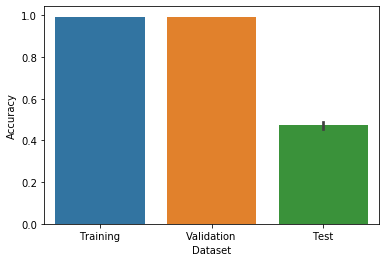

In [260]:
sns.barplot(data=df_acc_bar, x='Dataset', y='Accuracy')

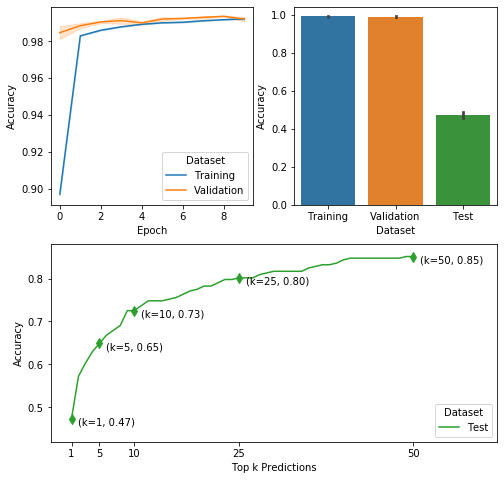

In [282]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.lineplot(data=df_results_melt, x='Epoch', y='Accuracy', hue='Dataset', ci='sd', ax=ax1)
sns.barplot(data=df_acc_bar, x='Dataset', y='Accuracy', ci='sd', ax=ax2)

t=0
accuracies = df_results_test[df_results_test['trial']==t]['Accuracy'].values
k_values = df_results_test[df_results_test['trial']==t]['k'].values

pnts = [1, 5, 10, 25, 50]
ax3.plot(k_values, accuracies, c='tab:green', label='Test')
pnts = np.array(pnts) - 1
k_sub, acc_sub = k_values[pnts], accuracies[pnts]
ax3.scatter(k_sub, acc_sub, marker='d', s=50, c='tab:green')
text = [f"(k={k_values[idx]}, {accuracies[idx]:.2f})" for idx in pnts]
for idx in range(len(pnts)):
    ax3.text(k_sub[idx]+1, acc_sub[idx]-0.015, text[idx])
    
ax3.set_xlim(-2, 62)
ax3.set_ylim(0.42, 0.88)
ax3.set_xticks(pnts+1)
ax3.set_xlabel('Top k Predictions')
ax3.set_ylabel('Accuracy')
ax3.legend(loc='lower right', title='Dataset')

fig.tight_layout
# plt.savefig('./Synthetic/basic_classification_results/plots/classification_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

In [284]:
# results

In [287]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()

    # Make input tensor require gradient
    X.requires_grad_()

    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                    #
    ##############################################################################
    # Replace "pass" statement with your code

    # forward pass
    scores = model(X)

    # encode correct scores
    y_encode = torch.zeros_like(scores)
    y_encode[torch.arange(y.shape[0]), y]=1

    # get correct scores
    correct_scores = y_encode * scores

    # sum into loss
    loss = correct_scores.sum()

    # backward pass
    loss.backward()

    # compute saliencey  
    saliency = X.grad # get gradient
    saliency = saliency.abs() # take absolute value
    saliency, indices = torch.max(saliency, dim=1) # https://pytorch.org/docs/stable/generated/torch.max.html

    ##############################################################################
    #               END OF YOUR CODE                 #
    ##############################################################################
    return saliency

In [290]:
model = torch.load('./Synthetic/basic_classification_results/trial2-EfficientNet-10-Adam-001-0/model_entire.pth')
# model = torch.load('./Synthetic/basic_classification_results/trial2-EfficientNet-10-Adam-001-0/model_entire.pth')

In [425]:
for b in dataloader_train:
    break
X, y = b

X = X.to(device=device)
y = y.to(device=device)
model = model.to(device=device)

saliency = compute_saliency_maps(X, y, model)

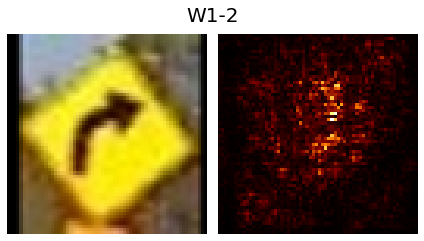

In [571]:
sm_dir = './Synthetic/saliency-maps'

cmap='afmhot'

idx=np.random.randint(len(X))

x_show = X[idx].clone()
x_show = unnormalize_image(x_show.clone().detach().to(device='cpu')).transpose((1, 2, 0))
s_show = saliency[idx].clone().detach().cpu()


fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(x_show)
ax[1].imshow(s_show, cmap=cmap)

fig.suptitle(f'{label_decoder[y[idx].item()].upper()}', y=0.94, fontsize=20)
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

In [572]:
sm_dir = './Synthetic/saliency-maps'

cmap='afmhot'

# idx=np.random.randint(len(X))
for idx in range(len(X)):
    x_show = X[idx].clone()
    x_show = unnormalize_image(x_show.clone().detach().to(device='cpu')).transpose((1, 2, 0))
    s_show = saliency[idx].clone().detach().cpu()


    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(x_show)
    ax[1].imshow(s_show, cmap=cmap)
    
    fig.suptitle(f'{label_decoder[y[idx].item()].upper()}', y=0.94, fontsize=20)

    for a in ax:
        a.axis('off')
    plt.tight_layout()

    plt.savefig(os.path.join(sm_dir, f"{label_decoder[y[idx].item()]}_{idx:03}"), dpi=200, bbox_inches='tight')
    plt.close()